In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import warnings
import numpy as np
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

In [5]:
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [6]:
start = time.time()
df = pd.read_csv('energy.csv')
end = time.time()
print(f"Loading took  {str(round(end - start, 2))} seconds")

Loading took  0.04 seconds


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
start_date = pd.to_datetime('2012-01-01 00:00:00')
end_date = pd.to_datetime('2014-12-31 23:00:00')  # Replace with the correct date

In [8]:
filtered_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

Loading data file now, this could take a while depending on file size
Loading took 0.04 seconds


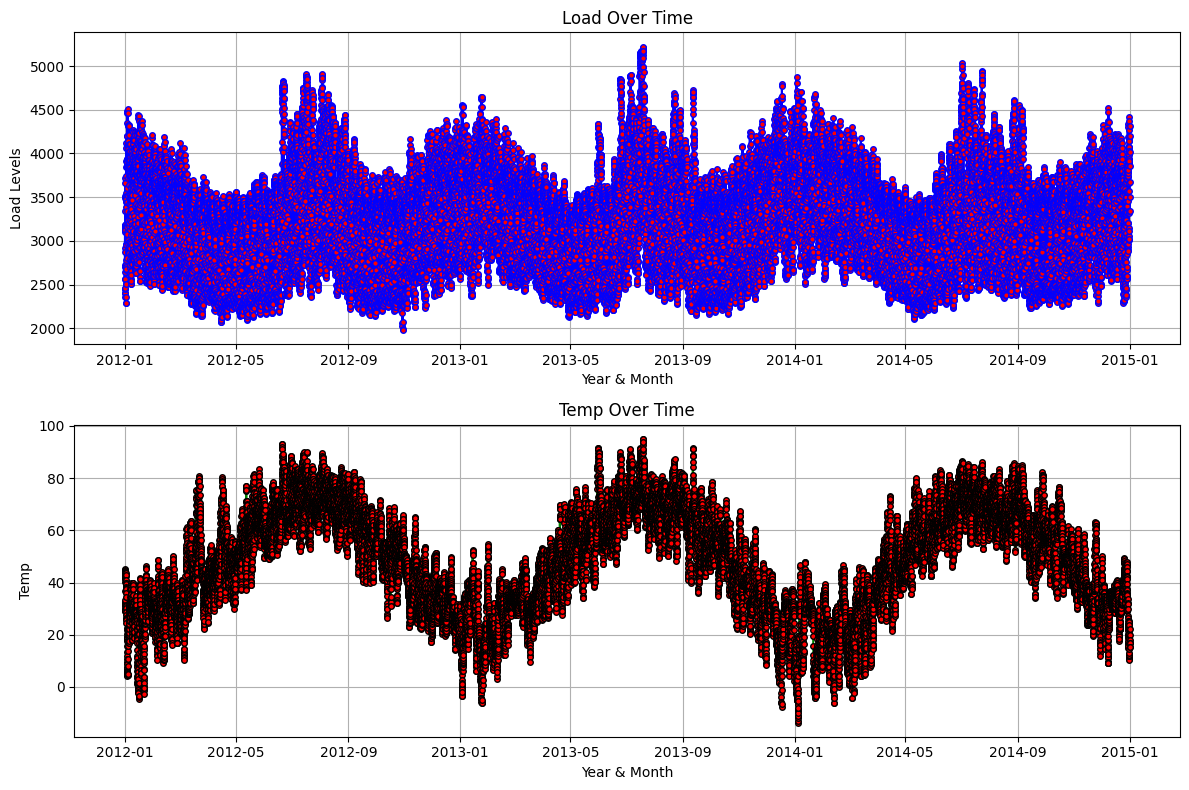

In [9]:
# Create a figure and two subplots
plt.figure(figsize=(12, 8))
print("Loading data file now, this could take a while depending on file size")
# First subplot: CO2 vs Year&Month
start_1 = time.time()
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
plt.plot(filtered_df['timestamp'], filtered_df['load'], marker='o', markersize=4, markerfacecolor='red', color='blue')
plt.xlabel('Year & Month')
plt.ylabel('Load Levels')
plt.title('Load Over Time')
plt.grid(True)
# Second subplot: Tree vs Year&Month
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd plot
plt.plot(filtered_df['timestamp'], filtered_df['temp'], color='green',marker='o',markersize=4,markerfacecolor='red',markeredgecolor='Black')
plt.xlabel('Year & Month')
plt.ylabel('Temp')
plt.title('Temp Over Time')
plt.grid(True)
end_1 = time.time()
print("Loading took " + str(round(end_1 - start_1, 2)) + " seconds")
# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

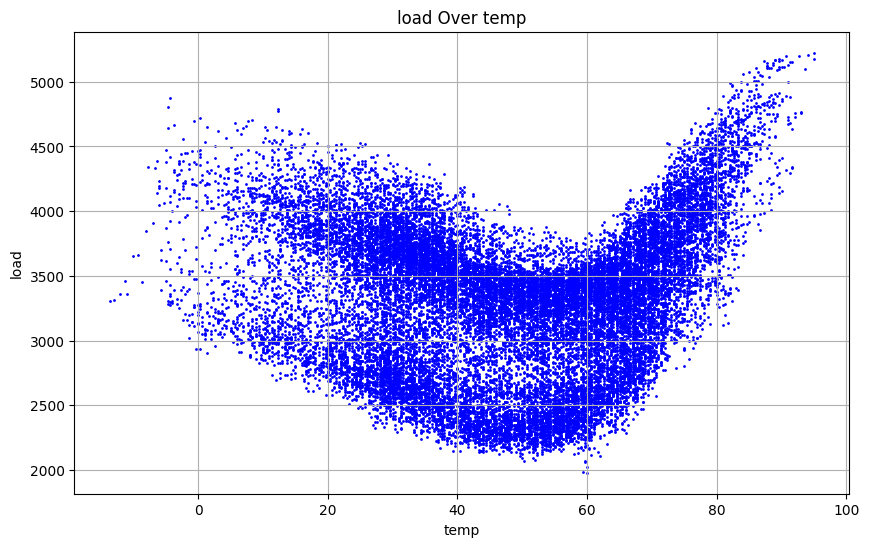

In [10]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(df['temp'], df['load'],s=1, color='blue')
# Add labels and title
plt.xlabel('temp')
plt.ylabel('load')
plt.title('load Over temp')
# Show the plot
plt.grid(True)
plt.show()

In [11]:
data_dir = '..\ex08'
energy = load_data(data_dir)[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


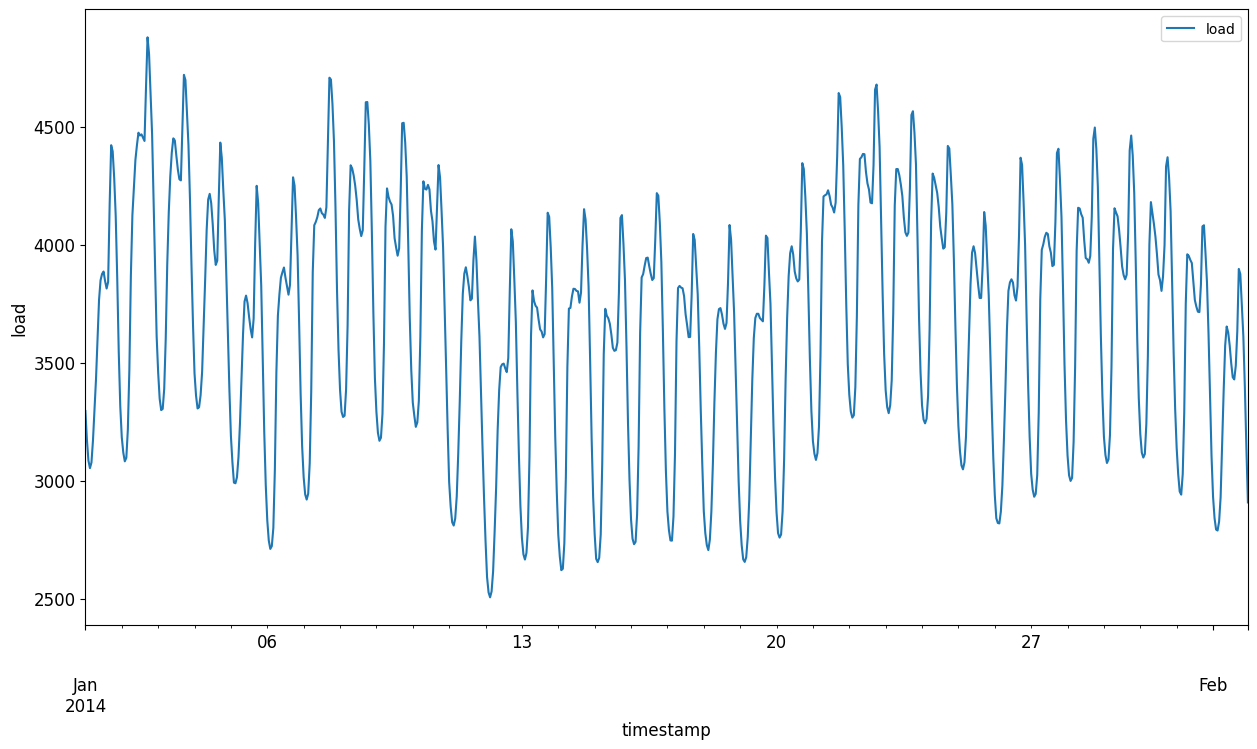

In [12]:
energy['2014-01-01':'2014-02-01'].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

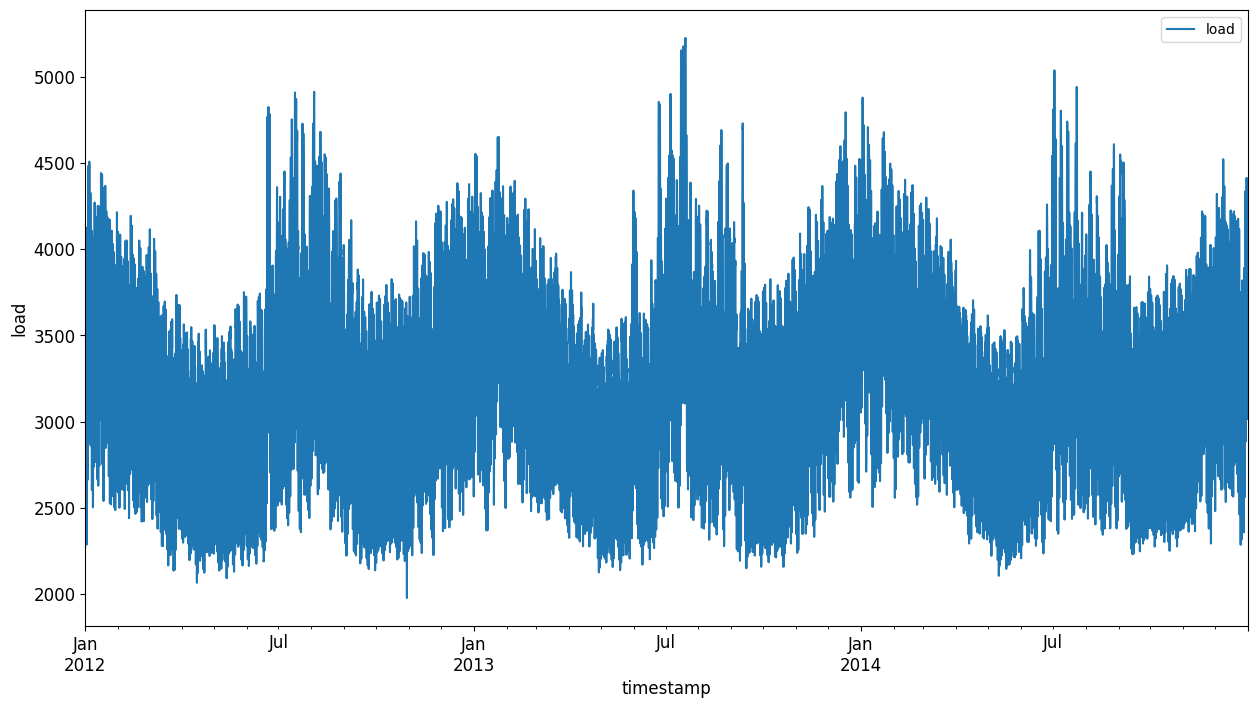

In [13]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

# Create training and testing datasets

In [14]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-15 00:00:00'

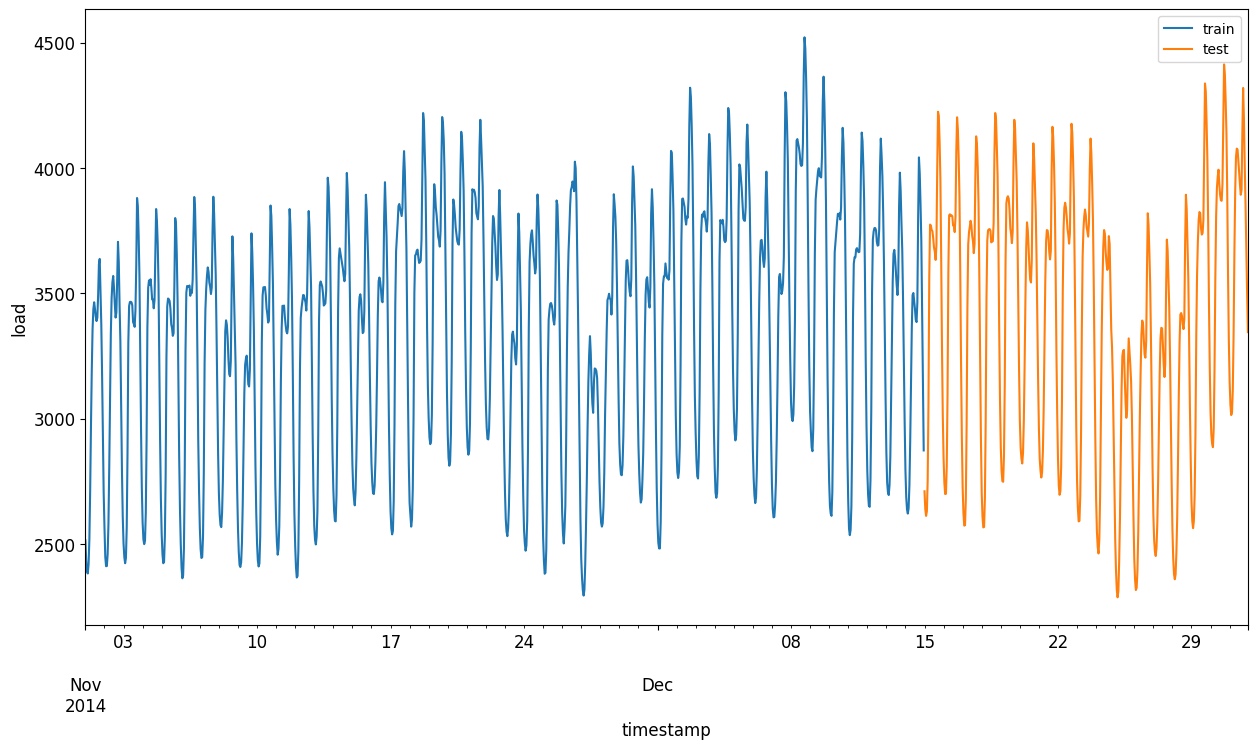

In [15]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

# Prepare the data for training

In [16]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1056, 1)
Test data shape:  (408, 1)


In [17]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)

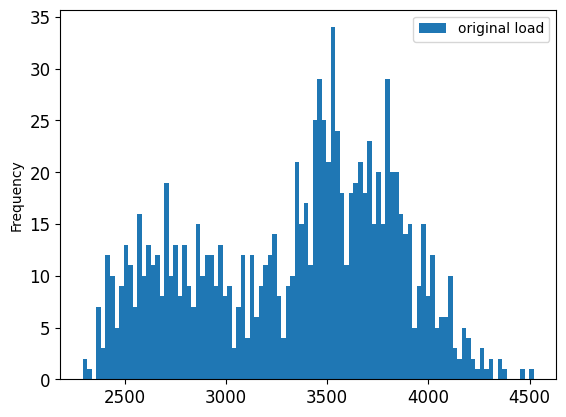

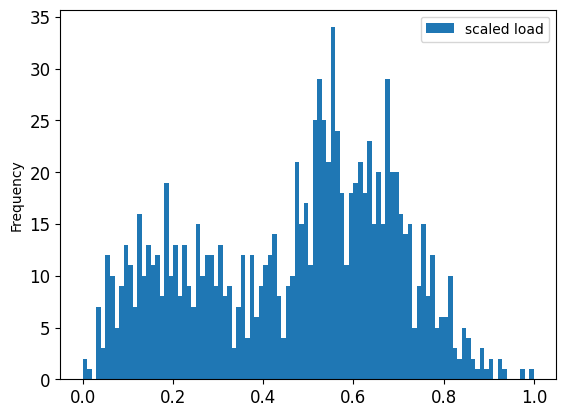

In [18]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [19]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-12-15 00:00:00,0.19
2014-12-15 01:00:00,0.15
2014-12-15 02:00:00,0.14
2014-12-15 03:00:00,0.15
2014-12-15 04:00:00,0.21


# Implement ARIMA method

In [20]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [21]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1056
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                2542.199
Date:                            Sat, 14 Sep 2024   AIC                          -5072.397
Time:                                    20:00:55   BIC                          -5042.768
Sample:                                11-01-2014   HQIC                         -5061.153
                                     - 12-14-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8112      0.018     44.246      0.000       0.775       0.847
ar.L2         -0.4954      0.038   

# Evaluate your model

In [22]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2
2014-12-15 00:00:00,0.19,0.15,0.14
2014-12-15 01:00:00,0.15,0.14,0.15
2014-12-15 02:00:00,0.14,0.15,0.21
2014-12-15 03:00:00,0.15,0.21,0.35
2014-12-15 04:00:00,0.21,0.35,0.57


In [23]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-15 00:00:00
1 : predicted = [0.18 0.14 0.12] expected = [0.18679838347552757, 0.1544678940278401, 0.1427929950606197]
2014-12-15 01:00:00
2 : predicted = [0.15 0.13 0.13] expected = [0.1544678940278401, 0.1427929950606197, 0.15087561742254163]
2014-12-15 02:00:00
3 : predicted = [0.14 0.13 0.14] expected = [0.1427929950606197, 0.15087561742254163, 0.2056578356533454]
2014-12-15 03:00:00
4 : predicted = [0.14 0.14 0.19] expected = [0.15087561742254163, 0.2056578356533454, 0.3457566232599911]
2014-12-15 04:00:00
5 : predicted = [0.17 0.21 0.29] expected = [0.2056578356533454, 0.3457566232599911, 0.5716210148181411]
2014-12-15 05:00:00
6 : predicted = [0.28 0.37 0.46] expected = [0.3457566232599911, 0.5716210148181411, 0.6645711719802425]
2014-12-15 06:00:00
7 : predicted = [0.49 0.6  0.69] expected = [0.5716210148181411, 0.6645711719802425, 0.6627750336775933]
2014-12-15 07:00:00
8 : predicted = [0.75 0.87 0.9 ] expected = [0.6645711719802425, 0.6627750336775933, 0.65514144589133

In [24]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-12-15 00:00:00,t+1,"2,697.38","2,710.00"
1,2014-12-15 01:00:00,t+1,"2,629.75","2,638.00"
2,2014-12-15 02:00:00,t+1,"2,607.12","2,612.00"
3,2014-12-15 03:00:00,t+1,"2,598.62","2,630.00"
4,2014-12-15 04:00:00,t+1,"2,673.79","2,752.00"


## Check model accuracy

In [25]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.01
t+2   0.02
t+3   0.02
Name: APE, dtype: float64


In [26]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  0.7947000051758558 %


In [27]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  1.6407673300911627 %


Plot the predictions vs the actuals for the first week of the test set

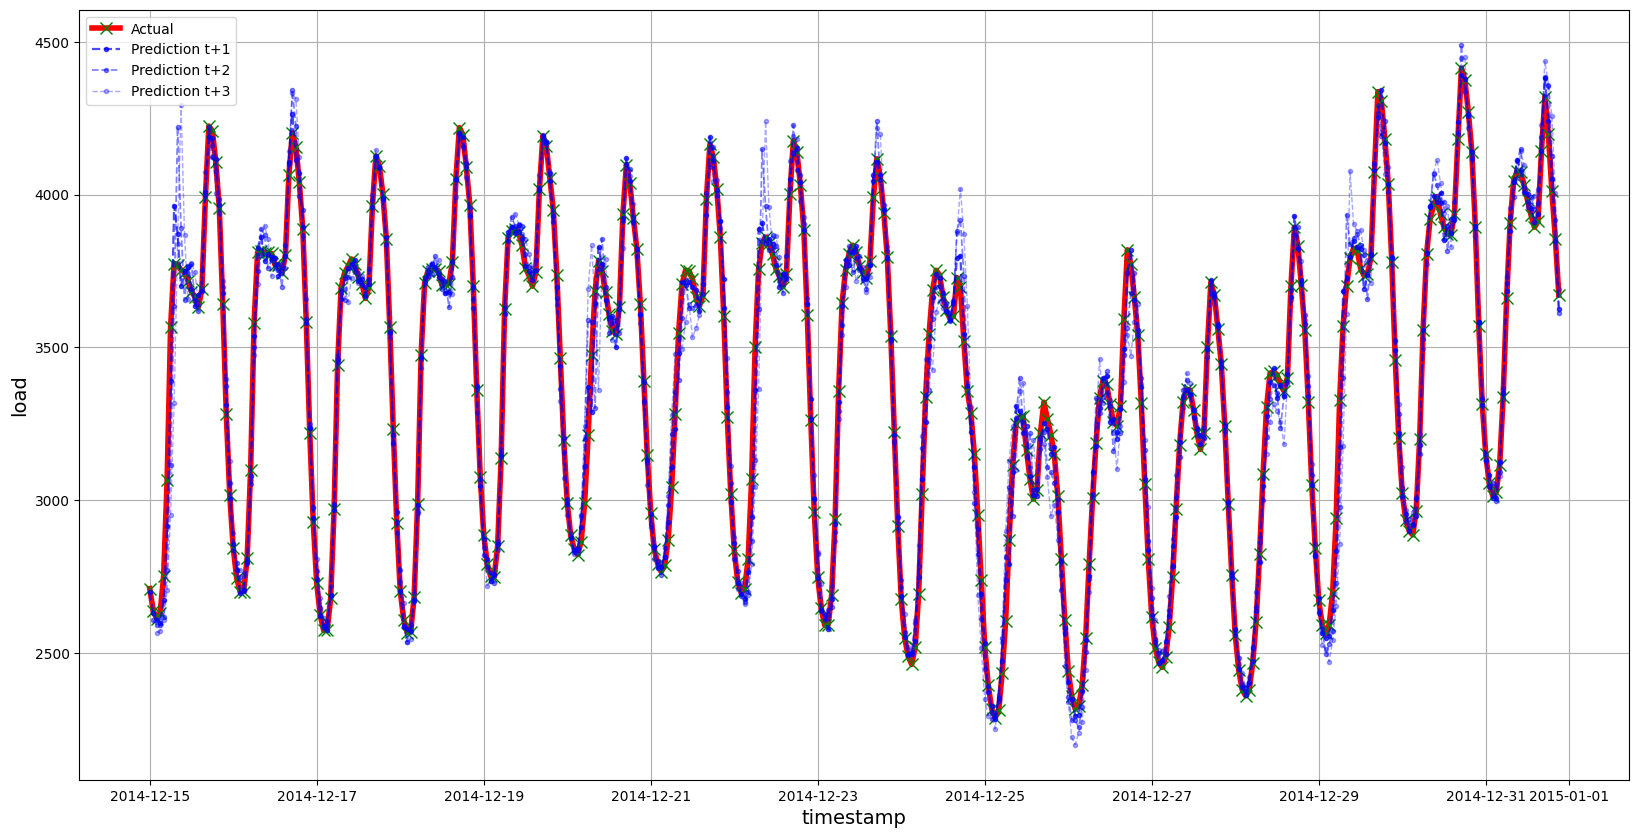

In [28]:
if HORIZON == 1:
    # Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', '--b'], figsize=(15, 8))

else:
    # Plotting multi step forecast
    plot_df = eval_df[(eval_df.h == 't+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON + 1):
        plot_df['t+' + str(t)] = eval_df[(eval_df.h == 't+' + str(t))]['prediction'].values

    fig, ax = plt.subplots(figsize=(20, 10))

    # Plotting Actual
    ax.plot(plot_df['timestamp'], plot_df['actual'], marker='x', markersize=8, markerfacecolor='black', 
            markeredgecolor='green', color='red', linewidth=4.0, label='Actual')
    
    # Plotting Predictions
    for t in range(1, HORIZON + 1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+' + str(t)][0:len(x)]
        ax.plot(x, y, linestyle='--', marker='o', markersize=3, markerfacecolor='blue', markeredgecolor='blue', 
                color='blue', linewidth=2*math.pow(0.8, t), alpha=math.pow(0.7, t), label=f'Prediction t+{t}')

    ax.legend(loc='best')

    plt.xlabel('timestamp', fontsize=14)
    plt.ylabel('load', fontsize=14)
    plt.grid(True)  # เพิ่ม grid เพื่อให้ดูชัดเจนขึ้น
    plt.show()